In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_human_functions import heatmap, normalize_by_l2_norm, mse_matrix, Nexis_error
from functools import partial
from scipy.stats import pearsonr
from Nexis_human_model import run_Nexis
# Added
from scipy.integrate import odeint, ODEintWarning
import warnings

## Preparing Inputs

In [2]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix original.csv')

# List of striatal regions to exclude from further analysis CAN EDIT THIS
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix 
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

In [3]:
# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary') <---------
init_vec_method = 'baseline'    # was 'binary' 

# Conversion of ADNI region order to match connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

# Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    init_con = pandas.read_csv('Regional tau time series.csv')

    # Housekeeping
    init_con = init_con.drop('Unnamed: 0',axis=1)

    # Reorder regions 
    init_con_reordered = init_con.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    columns_to_delete = init_con_reordered.columns[excluded_indices]
    init_con_excluded = init_con_reordered.drop(columns_to_delete, axis = 1)

    # Take the first row (time point 0) as initial vector
    init_vec = init_con_excluded.iloc[0].values

    # Set use_baseline NEXIS input to 1 to indicate use of baseline data as initial vector  
    use_baseline_ = 0 # was 1  

# Binary vector indicating seeding location 
if init_vec_method == 'binary': 

    seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # MANUALLY EDIT SEEDING LOCATION HERE
    seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding locations to 1 (both left and right hemisphere)
    init_vec[seeding_indices[0]] = 1 
    init_vec[seeding_indices[1]] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 

In [4]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Conversion of DK region order to match that of connectivity matrix 
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [5]:
# LOAD GENE DATA HERE (assuming DK region order) <-----------
gene_data = pandas.read_csv('DK_Atlas_86_abagen_mapped_100-gene_exp_LcRcLsRs.csv')

# SELECT genes of choice (should be a matrix of nROI x number of genes) <---------
selected_gene = ['ABCA1']
gene_data_selected = gene_data.loc[:, selected_gene]
gene_data_array = gene_data_selected.to_numpy()

# Reorder and delete striatal regions 
gene_data_reordered = gene_data_array[new_order_DK, :]
gene_data_excluded = np.delete(gene_data_reordered,excluded_indices)
gene_data_excluded = gene_data_excluded.reshape(78,1)


In [6]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
init_vec_ = init_vec # Initial tau vector (nROI x 1)
t_vec_ = np.linspace(0, 15, 16)  # Time vector in terms of stages outputted by EBM (19 stages)
w_dir_ = 0  # Set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without
datadir_ = "../NDM output/NDM_output.csv"  # Data directory for output

# Cell type matrix (nROI x nTypes)
U_global_= np.zeros((nROI, 1))
U_gene_= gene_data_excluded 

## Load Patient Data

In [7]:
# Upload patient data
patient_data = pandas.read_csv('Cross-sectional stage and regional tau.csv')

# Reorder regions
subset_columns = patient_data.columns[3:][new_order_ADNI]  
final_columns = list(patient_data.columns[:3]) + list(subset_columns)
patient_data = patient_data[final_columns]

# Delete striatal regions 
patient_data = patient_data.drop(regions_to_exclude, axis = 1)

In [8]:
# If analyzing an individual patient... (use this to test that the model is working before looping through all patients)

# Added on Jun 10 as per Robin
#CN = patient_data[patient_data['Diagnosis'] == 0]
#sample_size = 100  # SET SAMPLE SIZE HERE
#CN_sample = CN.sample(n=sample_size, random_state=1)
#MCI_AD = patient_data[patient_data['Diagnosis'] != 0]
#patient_data = pandas.concat([CN_sample, MCI_AD])
# End

# To revisit -- farras
#tt = patient_data #[patient_data['Diagnosis'] == 1]
#aa = list(MCI_AD['RID'].items())
aa = list(patient_data['RID'].items())

# End

patient = patient_data[patient_data['RID'] == 680] #680 aa[113][1]] # MANUALLY SET RID HERE was 6721 aa[360][1], 56 <----------

#patient = MCI_AD[MCI_AD['RID'] == aa[36][1]]

# Define number of time points 
num_time_points = patient.shape[0]

# Define list with stage assingments for each time point 
stages = patient['ml_stage'].tolist()
stages = [int(x) for x in stages]

# Define patient tau data
patient_tau = patient.iloc[:,3:]

# Convert to array and transpose so dim = nROI x # of stages
patient_tau = patient_tau.to_numpy()
patient_tau = patient_tau.T

In [9]:
print(patient)

    Unnamed: 0  RID  Diagnosis  ctx-lh-insula  Left-Cerebellum-Cortex  \
25          25  680          1       0.083458                0.015126   

    Left-Thalamus-Proper  Left-Hippocampus  Left-Amygdala  Left-VentralDC  \
25              0.271831          0.322959       0.272121        0.306819   

    Right-Cerebellum-Cortex  ...  ctx-rh-precuneus  \
25                -0.015126  ...          0.093123   

    ctx-rh-rostralanteriorcingulate  ctx-rh-rostralmiddlefrontal  \
25                         0.040835                    -0.059489   

    ctx-rh-superiorfrontal  ctx-rh-superiorparietal  ctx-rh-superiortemporal  \
25               -0.094766                 -0.11313                -0.019765   

    ctx-rh-supramarginal  ctx-rh-frontalpole  ctx-rh-temporalpole  \
25             -0.040062           -0.104721             0.057749   

    ctx-rh-transversetemporal  
25                  -0.015899  

[1 rows x 81 columns]


## Parameter Optimization

In [10]:
# SET LAMBDA HERE (for L1 regularization) <------------ L1
Lambda = 0.   # 0.000001

def Nexis_error(params, patient_tau, stages, nexis_model):

    try: 
        param1, param2, param3, param4, param5, param6, param7 = params 
        # param1 = alpha, param2 = beta, param3 = gamma, param4 = s, param5 = b, param6 = p, param7 = k

        # Parameters for simulate_nexis method
        parameters = [param1, param2, param3, param4, param5, param6, param7]  # [alpha, beta, gamma, s, b, p , k] 

        # Call the simulate_nexis method with the parameters
        Y = nexis_model.simulate_nexis(parameters)

        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages]

        # Calculate R
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        #error = mse_matrix(patient_tau, Y_edited) + (1- corr_coeff) + Lambda * param1.sum()
        error = mse_matrix(patient_tau, Y_edited) + 0.5 * (1 - corr_coeff)

        if np.isnan(error) or np.isinf(error):
            raise ValueError("Invalid result")
        
    except Exception as e:
        # Handle the error and return a large penalty value
        error = 1e10
        
    return error

In [11]:
# Initialize nexis global
nexis_model_global = run_Nexis(C_=C_, U_=U_global_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                      volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                       region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

# Initialize nexis gene 
nexis_model_gene = run_Nexis(C_=C_, U_=U_gene_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                       volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                       region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)

In [12]:
# Choose which model to run ('global' or 'gene') <--------------
model = 'gene'

# minimize tolerance:
ftol = 1e-6 #1e-4
gtol = 1e-6 #1e-4

# Set initial guesses for parameters for global model (alpha, beta, gamma, s, b, p, k) CAN ADJUST THESE
init_guess_global = np.array([0.04, 1.01, 1, 0.5, 0, 0, 20])
# Set bounds for each parameter for global model [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. CAN ADJUST THESE
bounds_global = [(0, 2),(0, 5),(0,3),(0.5, 0.5),(0,0),(0,0),(0,50)]

 # Set initial guesses for parameters for gene model(CAN ADJUST THESE)
#init_guess_gene = np.array([0.04, 1.01, 1, 0.5, 1, 1, 20])

#init_guess_gene = np.array([0.04, 1.01, 1, 0.5, 0, 0, 20])
init_guess_gene = np.array([0.2, 1.01, 0.5, 0.5, 0, 0, 20])

# Set bounds for each parameter for gene model (CAN ADJUST THESE)
#bounds_gene = [(0, 2),(0, 5),(0,3),(0.5, 0.5),(-5,5),(-5,5),(0,50)]
bounds_gene = [(0, 2),(0, 5),(0,3),(0.5, 0.5),(-1,5),(-1,5),(20,20)]

# Customize error function for patient tau, stages, and version of Nexis (gene and global)
custom_Nexis_error_global = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_global)
custom_Nexis_error_gene = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_gene)

# Perform the optimization (currently set to global) 
if model == 'global':

    result = minimize(custom_Nexis_error_global, init_guess_global, bounds=bounds_global, method='L-BFGS-B', 
                  options={'ftol': ftol, 'gtol': gtol})
else: 

    result = minimize(custom_Nexis_error_gene, init_guess_gene, bounds=bounds_gene, method='L-BFGS-B', 
                  options={'ftol': ftol, 'gtol': gtol})

# Check the results
if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist( )
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
else:
    print("Optimization failed.", result.message)

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.0, 0.0, 0.2878692614342021, 0.5, -1.0, 0.5656819469004152, 20.0]


In [13]:
#patient_data

## Running Nexis

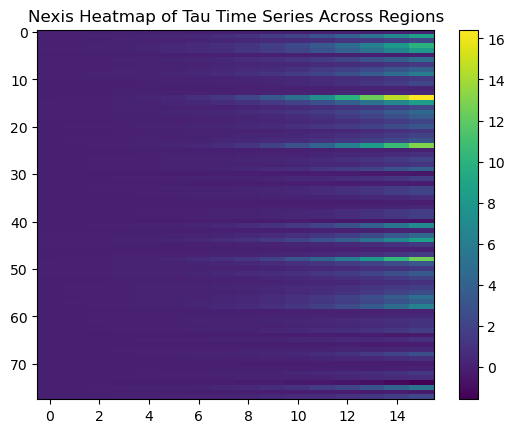

In [14]:
# Parameters for simulate_nexis method
parameters = optimized_params  # (alpha, beta, gamma, b, p, k) CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the optimized parameters 
if model == 'global':
    Y = nexis_model_global.simulate_nexis(parameters)
else:
    Y = nexis_model_gene.simulate_nexis(parameters)

# Take stages from Y that correspond to patient's stages 
Y_edited = Y[:, stages]

# Plot heatmap of Y
plt = heatmap(init_vec_method, Y)

## Check Results

In [15]:
# Calculate Pearson's correlation coefficient R 
patient_tau_reshaped = patient_tau.reshape(-1)
Y_edited_reshaped = Y_edited.reshape(-1)
R, p_value = pearsonr(patient_tau_reshaped, Y_edited_reshaped)
print("Pearson's R:", R)
print("P-value:", p_value)

# Calculate MSE between EBM data and Y
mse = mse_matrix(patient_tau, Y_edited)
print('Mean squared error: ' + str(mse))

Pearson's R: 0.2520667526516197
P-value: 0.025991893080168013
Mean squared error: 0.3052414701344323


In [16]:
#patient_tau_reshaped = patient_tau.reshape(-1)
#Y_edited_reshaped = Y_edited.reshape(-1)
#patient_tau_reshaped.shape

<function matplotlib.pyplot.show(close=None, block=None)>

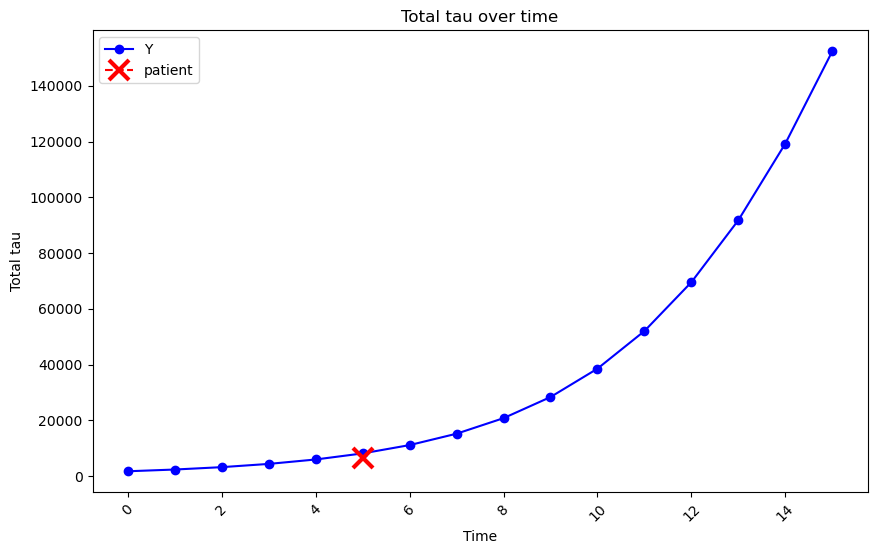

In [17]:
# Plot total tau over time 

# Calculate total tau based on regional volumes and tau density 
regional_volumes_array = np.array(regional_volumes_excluded)
regional_volumes_array = regional_volumes_array.reshape((78,1))
tau_mass_Y = regional_volumes_array * Y 
total_tau_Y = np.sum(tau_mass_Y, axis=0)
tau_mass_patient = regional_volumes_array * patient_tau
total_tau_patient = np.sum(tau_mass_patient, axis=0)

time_points_Y = np.linspace(0, 15, 16)

plt.figure(figsize=(10, 6))

# Plot total_tau_Y
plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

# Plot total_tau_patient on the same graph
plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)
plt.title('Total tau over time') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Total tau')  # Label the y-axis
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.legend()  # Add a legend to distinguish the two lines

# Show the plot
plt.show

## Loop through all genes and individuals 

In [18]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()
# unique_rids = [21]
# Create a list of all genes
gene_list = gene_data.columns.tolist()
# Create a dictionary of DataFrames for each gene
results = {}
column_names = ['RID', 'Model', 'R squared', 'alpha', 'beta', 'gamma', 's', 'p', 'b', 'k']
warnings.filterwarnings("ignore", category=ODEintWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
for gene in gene_list:
    gene_title = gene  # This gives you the column title as a string
    gene_data_selected = gene_data[[gene]]  # This gives you the column data
    # Create a DataFrame for selected gene as entry in dictionary
    results[gene_title] = pandas.DataFrame(columns=column_names)
    # Loop through all patients
    for rid in unique_rids:
        patient = patient_data[patient_data['RID'] == rid]
        # Define number of time points
        num_time_points = patient.shape[0]
        # Define list with stage assignments for each time point
        stages = patient['ml_stage'].tolist()
        stages = [int(x) for x in stages]
        # Define patient tau data
        patient_tau = patient.iloc[:, 3:]
        # Convert to array and transpose so dim = nROI x # of stages
        patient_tau = patient_tau.to_numpy()
        patient_tau = patient_tau.T
        patient_tau_reshaped = patient_tau.reshape(-1)
        # Run Nexis global and calculate R squared
        custom_Nexis_error_global = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_global)
        result = minimize(custom_Nexis_error_global, init_guess_global, bounds=bounds_global, method='L-BFGS-B',
                          options={'ftol': 1e-4, 'gtol': 1e-4})
        if result.success:
            optimized_params_global = result.x
            optimized_params_global = optimized_params_global.tolist()
            Y = nexis_model_global.simulate_nexis(optimized_params_global)
            Y_edited = Y[:, stages]
            Y_edited_reshaped = Y_edited.reshape(-1)
            R_global, p_value_global = pearsonr(patient_tau_reshaped, Y_edited_reshaped)
            R_squared_global = R_global ** 2
        else:
            optimized_params_gene = [np.nan] * 7
            R_squared_gene = np.nan
        # Run Nexis with gene and calculate R squared
        gene_data_array = gene_data_selected.to_numpy()
        gene_data_reordered = gene_data_array[new_order_DK, :]
        gene_data_excluded = np.delete(gene_data_reordered,excluded_indices)
        gene_data_excluded = gene_data_excluded.reshape(78,1)
        U_gene_= gene_data_excluded
        nexis_model_gene = run_Nexis(C_=C_, U_=U_gene_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                       volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                       region_volumes_=region_volumes_, logistic_term_=logistic_term_, datadir_=datadir_)
        custom_Nexis_error_gene = partial(Nexis_error, patient_tau=patient_tau, stages=stages, nexis_model=nexis_model_gene)
        result = minimize(custom_Nexis_error_gene, init_guess_gene, bounds=bounds_gene, method='L-BFGS-B',
                          options={'ftol': 1e-4, 'gtol': 1e-4})
        if result.success:
            optimized_params_gene = result.x
            optimized_params_gene = optimized_params_gene.tolist()
            Y = nexis_model_gene.simulate_nexis(optimized_params_gene)
            Y_edited = Y[:, stages]
            Y_edited_reshaped = Y_edited.reshape(-1)
            if np.std(patient_tau) != 0 and np.std(Y_edited) != 0:
                R_gene, p_value_gene = pearsonr(patient_tau.flatten(), Y_edited.flatten())
            else:
                corr_coeff, p_value = np.nan, np.nan
            R_squared_gene = R_gene ** 2
        else:
            optimized_params_gene = [np.nan] * 7
            R_squared_gene = np.nan
        # Add to data frame
        new_rows = pandas.DataFrame({'RID': [rid, rid], 'Model': ['Global', 'Gene'],
                                 'R squared': [R_squared_global, R_squared_gene],
                                 'alpha': [optimized_params_global[0], optimized_params_gene[0]],
                                 'beta': [optimized_params_global[1], optimized_params_gene[1]],
                                 'gamma': [optimized_params_global[2], optimized_params_gene[2]],
                                 's': [optimized_params_global[3], optimized_params_gene[3]],
                                 'b': [optimized_params_global[4], optimized_params_gene[4]],
                                 'p': [optimized_params_global[5], optimized_params_gene[5]],
                                 'k': [optimized_params_global[6], optimized_params_gene[6]]})
        new_rows = new_rows.dropna(how='all')
        if not new_rows.empty:
            results[gene_title] = pandas.concat([results[gene_title], new_rows], ignore_index=True)

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202776661075D+02   r2 =  0.7683078809896D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202776661075D+02   r2 =  0.7683078809896D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202776661075D+02   r2 =  0.7683078809896D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202776661075D+02   r2 =  0.7683078809896D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8042980920850D+01   r2 =  0.7753793051216D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1408179132857D+02   r2 =  0.8211835156373D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1408179132857D+02   r2 =  0.8211835156373D-15


/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9001511312257D+01   r2 =  0.8377145127843D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9001511312257D+01   r2 =  0.8377145127843D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9001511312257D+01   r2 =  0.8377145127843D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9001511312257D+01   r2 =  0.8377145127843D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8080458494598D+01   r2 =  0.8017714494757D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8080450391327D+01   r2 =  0.8017639597231D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8080555048943D+01   r2 =  0.8018605190201D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8080435971382D+01   r2 =  0.8017506644852D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400270294866D+02   r2 =  0.7796642564602D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400270294866D+02   r2 =  0.7796642564602D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400270294866D+02   r2 =  0.7796642564602D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400270294866D+02   r2 =  0.7796642564602D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005700830736D+02   r2 =  0.8280849691736D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005700830736D+02   r2 =  0.8280849691736D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005700830736D+02   r2 =  0.8280849691736D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005700830736D+02   r2 =  0.8280849691736D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9076162433439D+01   r2 =  0.8114849734515D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9076162433439D+01   r2 =  0.8114849734515D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9076162371434D+01   r2 =  0.8114849616618D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9076162371434D+01   r2 =  0.8114849616618D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_model.py:99: RuntimeWarning: invalid value encountered in divide
  dydt = np.dot(A, y) - np.dot(Gamma,np.square(y)) / k
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_model.py:99: RuntimeWarning: divide by zero encountered in divide
  dydt = np.dot(A, y) - np.dot(Gamma,np.square(y)) / k


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 int

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20:

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000477586383D+01   r2 =  0.3899985800392D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000477586383D+01   r2 =  0.3899985800392D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000477586383D+01   r2 =  0.3899985800392D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000477586383D+01   r2 =  0.3899985800392D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000537649300D+01   r2 =  0.8425116347419D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000537649300D+01   r2 =  0.8425116347419D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000537649300D+01   r2 =  0.8425116347419D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000537649300D+01   r2 =  0.8425116347419D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8003139512672D+01   r2 =  0.8749748913262D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8003139512672D+01   r2 =  0.8749748913262D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8003139512672D+01   r2 =  0.8749748913262D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8003139424978D+01   r2 =  0.8749748742289D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 int

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20:

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102160913044D+02   r2 =  0.8068201992349D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102160913044D+02   r2 =  0.8068201992349D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102160913044D+02   r2 =  0.8068201992349D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102160913044D+02   r2 =  0.8068201992349D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8080633544332D+01   r2 =  0.8470181397371D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8080633544332D+01   r2 =  0.8470181397371D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8080633544332D+01   r2 =  0.8470181397371D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8009518926704D+01   r2 =  0.8211246657262D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1206388872695D+02   r2 =  0.8423942007626D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1206388872695D+02   r2 =  0.8423942007626D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1206388872695D+02   r2 =  0.6974877314397D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1206388872695D+02   r2 =  0.6974877314397D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8036801935872D+01   r2 =  0.8268350174816D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8036801935872D+01   r2 =  0.8268350174816D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8036801935872D+01   r2 =  0.6846049985973D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8036801935872D+01   r2 =  0.6846049985973D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207008748305D+02   r2 =  0.8428271023082D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207008748305D+02   r2 =  0.8428271023082D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207008748305D+02   r2 =  0.6978461663912D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207008748305D+02   r2 =  0.6978461663912D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9023897703780D+01   r2 =  0.7731348041814D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9023897703780D+01   r2 =  0.7731348041814D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9023897703780D+01   r2 =  0.7731348041814D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9023897703780D+01   r2 =  0.7731348041814D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103070321865D+02   r2 =  0.7791507141047D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103070321865D+02   r2 =  0.7791507141047D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103070321865D+02   r2 =  0.7791507141047D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103070321865D+02   r2 =  0.7791507141047D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000477438081D+01   r2 =  0.7351293545298D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000477438081D+01   r2 =  0.7351293545298D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000477438081D+01   r2 =  0.7351293545298D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000477438081D+01   r2 =  0.7351293545298D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022916881420D+01   r2 =  0.8565843559016D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022916881420D+01   r2 =  0.8565843559016D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022916881420D+01   r2 =  0.7092369329061D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022916881420D+01   r2 =  0.7092369329061D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010108459356D+01   r2 =  0.2126428244915D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010108459356D+01   r2 =  0.2126428244915D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010108459356D+01   r2 =  0.2126428244915D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010108459356D+01   r2 =  0.2126428244915D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9041747283264D+01   r2 =  0.7889228659373D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9041747283264D+01   r2 =  0.7889228659373D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9041747283264D+01   r2 =  0.7889228659373D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9041747283264D+01   r2 =  0.7889228659373D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7034087010232D+01   r2 =  0.3792898820355D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7034087010232D+01   r2 =  0.3792898820355D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7034087010232D+01   r2 =  0.3792898820355D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7034087010232D+01   r2 =  0.3792898820355D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400273910797D+02   r2 =  0.7732141555826D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400273910797D+02   r2 =  0.7732141555826D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400273910797D+02   r2 =  0.7732141555826D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400273910797D+02   r2 =  0.7732141555826D-15


/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200793730688D+02   r2 =  0.7540241845993D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200793730688D+02   r2 =  0.7540241845993D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200793730688D+02   r2 =  0.7540241845993D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200793730688D+02   r2 =  0.7540241845993D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300163026173D+02   r2 =  0.8016333765916D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300163026173D+02   r2 =  0.8016333765916D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300163026173D+02   r2 =  0.6637384787255D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300163026173D+02   r2 =  0.6637384787255D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203432732357D+02   r2 =  0.8828183858951D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203432732357D+02   r2 =  0.8828183858951D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203432732357D+02   r2 =  0.8828183858951D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203432732357D+02   r2 =  0.8828183858951D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8026755467828D+01   r2 =  0.8626638270231D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8026755467828D+01   r2 =  0.8626638270231D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8026755467828D+01   r2 =  0.8626638270231D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8026755467828D+01   r2 =  0.8626638270231D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000594055411D+02   r2 =  0.7838122130323D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000594055411D+02   r2 =  0.7838122130323D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000594055411D+02   r2 =  0.7838122130323D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000594055411D+02   r2 =  0.7838122130323D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100027039360D+02   r2 =  0.8517387100247D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100027039360D+02   r2 =  0.8517387100247D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100027039360D+02   r2 =  0.8517387100247D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100027039360D+02   r2 =  0.8517387100247D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1309338076561D+02   r2 =  0.8823915913395D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1006857335623D+02   r2 =  0.8195124238197D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1006857335623D+02   r2 =  0.8195124238197D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1006857335623D+02   r2 =  0.6785420185914D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406067159955D+02   r2 =  0.7436568022179D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406067159955D+02   r2 =  0.7436568022179D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406067159955D+02   r2 =  0.6157348845495D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406067159955D+02   r2 =  0.6157348845495D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103309822535D+02   r2 =  0.7968151722670D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103309822535D+02   r2 =  0.7968151722670D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103309822535D+02   r2 =  0.7968151722670D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1103309822535D+02   r2 =  0.7968151722670D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8086498010497D+01   r2 =  0.8819374473945D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8086498010497D+01   r2 =  0.8819374473945D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8086497934067D+01   r2 =  0.8819374171529D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8086497934067D+01   r2 =  0.8819374171529D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200190525884D+02   r2 =  0.7615958439721D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200190525884D+02   r2 =  0.7615958439721D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200190525884D+02   r2 =  0.7615958439721D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200190525884D+02   r2 =  0.7615958439721D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402806475856D+02   r2 =  0.7760768753502D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402806475856D+02   r2 =  0.7760768753502D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402806475856D+02   r2 =  0.7760768753502D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1402806475856D+02   r2 =  0.7760768753502D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6026651725112D+01   r2 =  0.3626713329405D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6026651725112D+01   r2 =  0.3626713329405D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6026651725112D+01   r2 =  0.3002855492953D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6026651725112D+01   r2 =  0.3002855492953D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9030248394388D+01   r2 =  0.7431714102274D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9030248394388D+01   r2 =  0.7431714102274D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9030248394388D+01   r2 =  0.7431714102274D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9030248394388D+01   r2 =  0.7431714102274D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005863674932D+02   r2 =  0.8261408631122D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005863674932D+02   r2 =  0.8261408631122D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005863674932D+02   r2 =  0.8261408631122D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1005863674932D+02   r2 =  0.8261408631122D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4026783265955D+01   r2 =  0.3711296826067D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4026783265955D+01   r2 =  0.3711296826067D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4026783265955D+01   r2 =  0.3072889155556D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4026783265955D+01   r2 =  0.3072889155556D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200261140088D+02   r2 =  0.8046679636198D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200261140088D+02   r2 =  0.8046679636198D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200261140088D+02   r2 =  0.6662510639885D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200261140088D+02   r2 =  0.6662510639885D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1108177753939D+02   r2 =  0.8747688500372D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1108177753939D+02   r2 =  0.8747688500372D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1108177753939D+02   r2 =  0.8747688500372D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1108177739719D+02   r2 =  0.8747688352163D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300295244000D+02   r2 =  0.8388353989852D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300295244000D+02   r2 =  0.8388353989852D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300295244000D+02   r2 =  0.6945411055102D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300295244000D+02   r2 =  0.6945411055102D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8054637246816D+01   r2 =  0.8333000365177D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8054637246816D+01   r2 =  0.8333000365177D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8054637246816D+01   r2 =  0.6899579219035D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8054637246816D+01   r2 =  0.6899579219035D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6022224347761D+01   r2 =  0.4059238247786D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6022224347761D+01   r2 =  0.4059238247786D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6022224347761D+01   r2 =  0.4059238247786D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6022224347761D+01   r2 =  0.4059238247786D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304715820674D+02   r2 =  0.8373311007771D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304715820674D+02   r2 =  0.8373311007771D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304715820674D+02   r2 =  0.8373311007771D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304715820674D+02   r2 =  0.8373311007771D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5005208686721D+01   r2 =  0.3904124917891D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5005208686721D+01   r2 =  0.3904124917891D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5005208686721D+01   r2 =  0.3232547458207D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5005208686721D+01   r2 =  0.3232547458207D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9004738151201D+01   r2 =  0.7129048619534D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9004738151201D+01   r2 =  0.7129048619534D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9004738151201D+01   r2 =  0.5902728134707D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9004738151201D+01   r2 =  0.5902728134707D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203381685468D+02   r2 =  0.7565197649172D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203381685468D+02   r2 =  0.7565197649172D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203381685468D+02   r2 =  0.7565197649172D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203381685468D+02   r2 =  0.7565197649172D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300041423981D+02   r2 =  0.8320660445338D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300041423981D+02   r2 =  0.8320660445338D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300041423981D+02   r2 =  0.8320660445338D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300041423981D+02   r2 =  0.8320660445338D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200050595339D+02   r2 =  0.8003289338769D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200050595339D+02   r2 =  0.8003289338769D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200050595339D+02   r2 =  0.8003289338769D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200050595339D+02   r2 =  0.8003289338769D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300119070752D+02   r2 =  0.7472376905537D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300119070752D+02   r2 =  0.7472376905537D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300119070752D+02   r2 =  0.7472376905537D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300119070752D+02   r2 =  0.7472376905537D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20:

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000898743962D+01   r2 =  0.4027761240846D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000898743962D+01   r2 =  0.4027761240846D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000898743962D+01   r2 =  0.4027761240846D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000898743962D+01   r2 =  0.4027761240846D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1107090521410D+02   r2 =  0.7816623244601D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1107090521410D+02   r2 =  0.7816623244601D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8001496058103D+01   r2 =  0.8386665677558D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8001496058103D+01   r2 =  0.8386665677558D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200113559719D+02   r2 =  0.8473309470998D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200113559719D+02   r2 =  0.8473309470998D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200113559719D+02   r2 =  0.7015752713950D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200113559719D+02   r2 =  0.7015752713950D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300198289388D+02   r2 =  0.7353312114840D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300198289388D+02   r2 =  0.7353312114840D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300198289388D+02   r2 =  0.7353312114840D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1300198289388D+02   r2 =  0.7353312114840D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8056294143035D+01   r2 =  0.8135798161725D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8056294143035D+01   r2 =  0.8135798161725D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8056294143035D+01   r2 =  0.6736299227651D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8056294143035D+01   r2 =  0.6736299227651D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/Users/farrasabdelnour/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304015013998D+02   r2 =  0.8784035986098D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304015013998D+02   r2 =  0.8784035986098D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304015013998D+02   r2 =  0.7273028858811D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1304015013998D+02   r2 =  0.7273028858811D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8075089342056D+01   r2 =  0.8676692550993D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8075089342056D+01   r2 =  0.8676692550993D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8075089342056D+01   r2 =  0.8676692550993D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8075089342056D+01   r2 =  0.8676692550993D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8035454586228D+01   r2 =  0.8557214871267D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8035454586228D+01   r2 =  0.8557214871267D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8035454586228D+01   r2 =  0.8557214871267D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8035454586228D+01   r2 =  0.8557214871267D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8084595432360D+01   r2 =  0.8545384946072D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8084595432360D+01   r2 =  0.8545384946072D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7000688587552D+01   r2 =  0.4140411529304D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7000688587552D+01   r2 =  0.4140411529304D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8008285655280D+01   r2 =  0.8408935417127D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8008285655280D+01   r2 =  0.8408935417127D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8008285655280D+01   r2 =  0.6962452119341D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8008285655280D+01   r2 =  0.6962452119341D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000267280588D+01   r2 =  0.7502951308661D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000267280588D+01   r2 =  0.7502951308661D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000267280588D+01   r2 =  0.7502951308661D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000267280588D+01   r2 =  0.7502951308661D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207504946409D+02   r2 =  0.7515002908994D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207504934410D+02   r2 =  0.7515002666777D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207504982738D+02   r2 =  0.7515004530196D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207504470952D+02   r2 =  0.7514992259777D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_model.py:99: RuntimeWarning: invalid value encountered in divide
  dydt = np.dot(A, y) - np.dot(Gamma,np.square(y)) / k
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_model.py:99: RuntimeWarning: divide by zero encountered in divide
  dydt = np.dot(A, y) - np.dot(Gamma,np.square(y)) / k


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1000000000000D+01   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 int

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307463175978D+02   r2 =  0.7946065002787D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307463175978D+02   r2 =  0.7946065002787D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307463153554D+02   r2 =  0.7946064397976D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307463153554D+02   r2 =  0.7946064397976D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102269140832D+02   r2 =  0.7213164441628D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102269140832D+02   r2 =  0.7213164441628D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102269140832D+02   r2 =  0.5972374570976D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1102269140832D+02   r2 =  0.5972374570976D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1004940596401D+02   r2 =  0.8192487824500D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1004940596401D+02   r2 =  0.8192487824500D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1004940596401D+02   r2 =  0.8192487824500D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1004940596401D+02   r2 =  0.8192487824500D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001045051002D+01   r2 =  0.3710323760642D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001045051002D+01   r2 =  0.3710323760642D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001045051002D+01   r2 =  0.3710323760642D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7001045051002D+01   r2 =  0.3710323760642D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20:

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9045849345952D+01   r2 =  0.7554830349824D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9045849345952D+01   r2 =  0.7554830349824D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9045849345952D+01   r2 =  0.6255267993667D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9045849345952D+01   r2 =  0.6255267993667D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207350017892D+02   r2 =  0.8489477050158D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207350017892D+02   r2 =  0.8489477050158D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207350017892D+02   r2 =  0.8489477050158D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207350017892D+02   r2 =  0.8489477050158D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307148737224D+02   r2 =  0.7884547305047D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307148737224D+02   r2 =  0.7884547305047D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307148708946D+02   r2 =  0.7884546872351D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1307148708946D+02   r2 =  0.7884546872351D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1108116813448D+02   r2 =  0.7778958796510D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000916529953D+01   r2 =  0.3677084324621D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000916529953D+01   r2 =  0.3677084324621D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000916529953D+01   r2 =  0.3677084324621D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6027319290767D+01   r2 =  0.4127587444498D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6027319290767D+01   r2 =  0.4127587444498D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6027319290767D+01   r2 =  0.3417570539604D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6027319290767D+01   r2 =  0.3417570539604D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000188128209D+02   r2 =  0.7244686514079D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000188128209D+02   r2 =  0.7244686514079D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000188128209D+02   r2 =  0.7244686514079D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000188128209D+02   r2 =  0.7244686514079D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000770101353D+01   r2 =  0.4107193425944D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000770101353D+01   r2 =  0.4107193425944D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000770101353D+01   r2 =  0.4107193425944D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000770101353D+01   r2 =  0.4107193425944D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/Clou

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000967870814D+01   r2 =  0.3989790712912D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000967870814D+01   r2 =  0.3989790712912D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000967870814D+01   r2 =  0.3989790712912D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000967870814D+01   r2 =  0.3989790712912D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4021058952869D+01   r2 =  0.4013608423702D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4021058952869D+01   r2 =  0.4013608423702D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4021058952869D+01   r2 =  0.3323197895055D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4021058952869D+01   r2 =  0.3323197895055D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000719265471D+01   r2 =  0.2012362143231D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000719265471D+01   r2 =  0.2012362143231D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000719265471D+01   r2 =  0.2012362143231D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000719258060D+01   r2 =  0.2012362133710D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400290990566D+02   r2 =  0.7330152045164D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400290957023D+02   r2 =  0.7330151834841D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400291069738D+02   r2 =  0.7330153042674D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400290988487D+02   r2 =  0.7330152047571D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000076326634D+02   r2 =  0.7223398617904D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000076326634D+02   r2 =  0.7223398617904D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000076326634D+02   r2 =  0.7223398617904D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000076326634D+02   r2 =  0.7223398617904D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1001318773676D+02   r2 =  0.7390774502799D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1001318773676D+02   r2 =  0.7390774502799D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1001318773676D+02   r2 =  0.7390774502799D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1001318773676D+02   r2 =  0.7390774502799D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/Users/farrasabdelnour/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient i

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203773581779D+02   r2 =  0.7311925974249D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203773581779D+02   r2 =  0.7311925974249D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203773581779D+02   r2 =  0.6054147400242D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1203773581779D+02   r2 =  0.6054147400242D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6035914763546D+01   r2 =  0.3720298874816D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6035914763546D+01   r2 =  0.3720298874816D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1302944595452D+02   r2 =  0.7942705796212D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1302944595452D+02   r2 =  0.7942705796212D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8074314597197D+01   r2 =  0.7686933053570D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8074314521735D+01   r2 =  0.7686932807263D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8074314720381D+01   r2 =  0.7686933773451D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8074314461016D+01   r2 =  0.7686932169364D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406266461304D+02   r2 =  0.7583520421267D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406266461304D+02   r2 =  0.7583520421267D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406266461304D+02   r2 =  0.6279022874191D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1406266461304D+02   r2 =  0.6279022874191D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5034184762275D+01   r2 =  0.3691962099307D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5034184762275D+01   r2 =  0.3691962099307D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5034184730237D+01   r2 =  0.3691962022689D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5034184730237D+01   r2 =  0.3691962022689D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8003392178189D+01   r2 =  0.8580861598779D-15


/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000318024754D+01   r2 =  0.2078291684940D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000318024754D+01   r2 =  0.2078291684940D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000318024754D+01   r2 =  0.2078291684940D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3000318024754D+01   r2 =  0.2078291684940D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1208055225243D+02   r2 =  0.8683574660642D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1208055225243D+02   r2 =  0.8683574660642D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1208055225243D+02   r2 =  0.8683574660642D-15


/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200701665405D+02   r2 =  0.8763515381202D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200701665405D+02   r2 =  0.8763515381202D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200701665405D+02   r2 =  0.8763515381202D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200701665405D+02   r2 =  0.8763515381202D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202601766254D+02   r2 =  0.8660678106258D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202601766254D+02   r2 =  0.8660678106258D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202601766254D+02   r2 =  0.8660678106258D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1202601766254D+02   r2 =  0.8660678106258D-15
 lsoda--  warning..internal t (=r1) 

/Users/farrasabdelnour/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8051410373622D+01   r2 =  0.8646099148708D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8051410373622D+01   r2 =  0.8646099148708D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8051410373622D+01   r2 =  0.7158819559229D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8051410373622D+01   r2 =  0.7158819559229D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3014345017886D+01   r2 =  0.1865287560935D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3014345017886D+01   r2 =  0.1865287560935D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3014345017886D+01   r2 =  0.1544425624385D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3014345017886D+01   r2 =  0.1544425624385D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6008645219186D+01   r2 =  0.4225856970273D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6008645219186D+01   r2 =  0.4225856970273D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6008645219186D+01   r2 =  0.4225856970273D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6008645219186D+01   r2 =  0.4225856970273D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022836044458D+01   r2 =  0.8273468302314D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022836044458D+01   r2 =  0.8273468302314D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022836044458D+01   r2 =  0.6850287706305D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9022836044458D+01   r2 =  0.6850287706305D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20:

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6010129318103D+01   r2 =  0.3922279376963D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6010129318103D+01   r2 =  0.3922279376963D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6010129318103D+01   r2 =  0.3247579034185D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6010129318103D+01   r2 =  0.3247579034185D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8062279640753D+01   r2 =  0.8620874649034D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8062279640753D+01   r2 =  0.8620874649034D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8062279640753D+01   r2 =  0.8620874649034D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8062279640753D+01   r2 =  0.8620874649034D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000491783612D+01   r2 =  0.3920701732450D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000491783612D+01   r2 =  0.3920701732450D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000491783612D+01   r2 =  0.3920701732450D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6000491783612D+01   r2 =  0.3920701732450D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000222069307D+01   r2 =  0.7561085195783D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000222069307D+01   r2 =  0.7561085195783D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000222069307D+01   r2 =  0.7561085195783D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9000222069307D+01   r2 =  0.7561085195783D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20:

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000859824722D+01   r2 =  0.4175944699401D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000859824722D+01   r2 =  0.4175944699401D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000859824722D+01   r2 =  0.4175944699401D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4000859824722D+01   r2 =  0.4175944699401D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/Clou

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9038618164660D+01   r2 =  0.7499027064930D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9038618164660D+01   r2 =  0.7499027064930D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9038618164660D+01   r2 =  0.7499027064930D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9038618164660D+01   r2 =  0.7499027064930D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1106806070975D+02   r2 =  0.8351304587847D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1106806070975D+02   r2 =  0.8351304587847D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1106806070975D+02   r2 =  0.6914734796291D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1106806070975D+02   r2 =  0.6914734796291D-15


/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9091656109583D+01   r2 =  0.8572203243257D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1101555278573D+02   r2 =  0.8311683940259D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1101555278573D+02   r2 =  0.8311683940259D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1101555278573D+02   r2 =  0.6881929590733D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1101814938275D+02   r2 =  0.8119476832107D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1101814938275D+02   r2 =  0.8119476832107D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1101814938275D+02   r2 =  0.8119476832107D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1101814938275D+02   r2 =  0.8119476832107D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000087874120D+02   r2 =  0.7330986646126D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000087874120D+02   r2 =  0.7330986646126D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000087874120D+02   r2 =  0.7330986646126D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000087874120D+02   r2 =  0.7330986646126D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000694763751D+02   r2 =  0.8619418785493D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000694763751D+02   r2 =  0.8619418785493D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000694763751D+02   r2 =  0.7136728683608D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000694763751D+02   r2 =  0.7136728683608D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9027791354208D+01   r2 =  0.8385139987386D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9027791354208D+01   r2 =  0.8385139987386D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9027791354208D+01   r2 =  0.6942749918458D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9027791354208D+01   r2 =  0.6942749918458D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100544632978D+02   r2 =  0.8777042694517D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100544632978D+02   r2 =  0.8777042694517D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100544632978D+02   r2 =  0.7267238536923D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100544632978D+02   r2 =  0.7267238536923D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200320933787D+02   r2 =  0.8713593547632D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200320933787D+02   r2 =  0.8713593547632D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200320933787D+02   r2 =  0.8713593547632D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1200320915158D+02   r2 =  0.8713593307513D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100335290133D+02   r2 =  0.8746550806788D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100335290133D+02   r2 =  0.8746550806788D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100335271158D+02   r2 =  0.8746550641257D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1100335271158D+02   r2 =  0.8746550641257D-15
 lsoda--  warning..internal t (=r1) 

/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
/Users/farrasabdelnour/Library/CloudStorage/Box-Box/Research/UCSF/git/Nexis-Human-main/Nexis_human_functions.py:39: RuntimeWarning: overflow encountered in square
  return np.mean((matrix1 - matrix2) ** 2)
/var/folders/k6/1ylf9yw149sbtbjmtxpdrtm00000gn/T/ipykernel_91853/2609361092.py:20:

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000238227779D+02   r2 =  0.7490637167290D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000238227779D+02   r2 =  0.7490637167290D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000238227779D+02   r2 =  0.7490637167290D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000238227779D+02   r2 =  0.7490637167290D-15
 lsoda--  warning..internal t (=r1) 

In [19]:
# Convert results from dictionary to one giant data frame
genes = []
for key, df in results.items():
    df_copy = df.copy()  
    df_copy['Gene'] = key 
    df_copy
    genes.append(df_copy)

all_genes = pandas.concat(genes, ignore_index=True)
cols = all_genes.columns.tolist()
cols = [cols[-1]] + cols[:-1]
all_genes = all_genes[cols]

all_genes


Gene   RID   Model  R squared     alpha      beta     gamma    s  \
0        ABCA1    21  Global   0.056543  0.136774  0.000000  1.000341  0.5   
1        ABCA1    21    Gene   0.069407  0.480729  0.278016  0.718023  0.5   
2        ABCA1    31  Global   0.028897  0.071812  0.000000  0.971671  0.5   
3        ABCA1    31    Gene   0.062808  0.707522  1.196003  0.692460  0.5   
4        ABCA1    56  Global   0.035829  0.031992  0.000000  1.000404  0.5   
...        ...   ...     ...        ...       ...       ...       ...  ...   
130395  ZNF184  6713    Gene   0.026511  0.031474  0.112774  0.451232  0.5   
130396  ZNF184  6721  Global   0.000589  0.144707  1.002975  1.011673  0.5   
130397  ZNF184  6721    Gene   0.035043  0.000000  0.137123  0.436624  0.5   
130398  ZNF184  6722  Global   0.075267  0.040000  1.010000  0.992139  0.5   
130399  ZNF184  6722    Gene   0.075267  0.200000  1.010000  0.505476  0.5   

               p         b          k  
0       0.000000  0.000000  20.000471  
1      -0.085407 -0.821211  20.000000  
2       0.000000  0.000000  20.000006  
3      -1.000000 -1.000000  20.000000  
4       0.000000  0.000000  20.000023  
...          ...       ...        ...  
130395  0.370059  5.000000  20.000000  
130396  0.000000  0.000000  20.000002  
130397  0.467697  5.000000  20.000000  
130398  0.000000  0.000000  20.000000  
130399  0.000000  0.000000  20.000000  

[130400 rows x 11 columns]

In [20]:
# Save to csv
filename = 'results.csv'
all_genes.to_csv(filename, index=False)

In [21]:
# OR save each gene to a seperate csv
for key, df in results.items():
    filename = f"{key}.csv" 
    df.to_csv(filename, index=False)  

## Plotting

In [24]:
aa = list(patient_data['RID'].items())

In [35]:
bb = aa[:][1]

In [27]:
unique_rids = patient_data['RID'].unique()

In [29]:
unique_rids[1]

6085

In [20]:
gene

AttributeError: 'Index' object has no attribute 'split'